### <font color="green"> SVM Model for Stock prediction using stock data and news semantic scores</font>

**Import Libraries**

In [ ]:
#Import Libraries
import math
import time
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as prep
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import GRU
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get the Stock Data and Visualize**

In [ ]:
#Fetch data from Yahoo finance 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26') 

#To get the stock data for companies Apple, Tesla, AMD and Disney uncomment the respective lines below
#df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#df = web.DataReader('AMD', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98
2016-07-27,6.98,6.68,6.93,6.85,38567300,6.85
2016-07-28,6.98,6.74,6.79,6.82,27515600,6.82


In [ ]:
#import sematic scores
newsScores=pd.read_csv('amd-scores.csv')
newsScores.head(3)

,date,final_semantic_score
0,2016-07-22,0.291504
1,2016-07-23,NaN
2,2016-07-24,NaN


In [ ]:
#Eleminate Nan values by replacing with previous value
newsScores=newsScores.ffill(axis=0)
newsScores.head(3)

,date,final_semantic_score
0,2016-07-22,0.291504
1,2016-07-23,0.291504
2,2016-07-24,0.291504


In [ ]:
df1=df.reset_index()
df1.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98


In [ ]:
#combine the semantic score with stock data
newsScores['date'] = pd.to_datetime(newsScores['date'])
merged_data = pd.merge(left=df1, right=newsScores, left_on='Date', right_on='date') #merge datasets
merged_data.drop(['date'], axis=1,inplace=True) #remove redundant column
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,final_semantic_score
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,0.291504
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70,0.291504
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98,0.291504


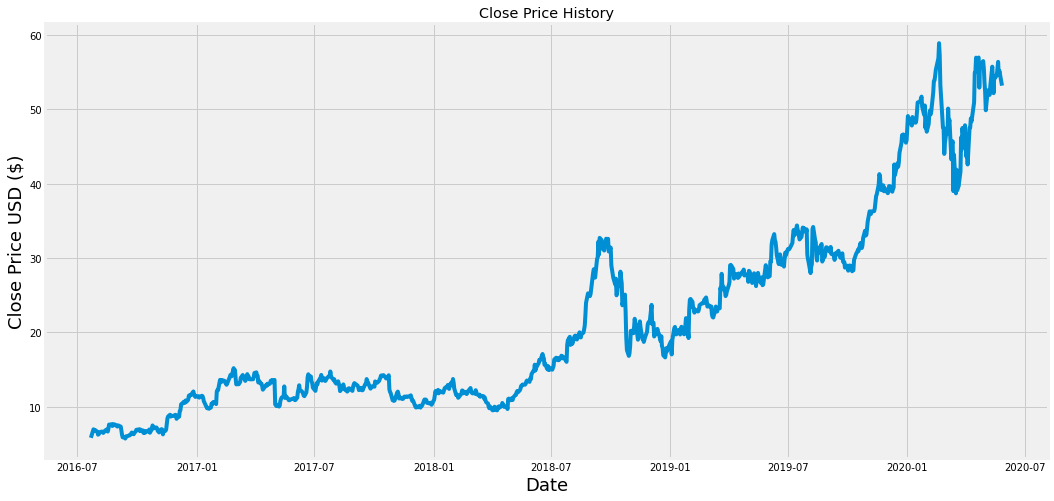

In [ ]:
#Visualizing the close price 
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(merged_data['Date'],merged_data['Close'] )
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Data Preprocessing**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = merged_data.filter(['Close','final_semantic_score'])

#Converting the dataframe to a numpy array
new_data = merged_data.filter(['Close']).values
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
##Data sclaing using minmax scaler
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
newScaler = MinMaxScaler(feature_range=(0, 1))
new_scaled_date = newScaler.fit_transform(new_data)

**Trainig Data and Test Data with Window Size 60**

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#test_data = scaled_data[training_data_len: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , :1 ] 
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

**SVM**

In [ ]:
#Import SVM Library
from sklearn import svm

In [ ]:
#Model creation
clf = svm.SVR()

#Model trainig
clf.fit(x_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#Test trained model
preds = clf.predict(x_test)
preds = preds.reshape(-1,1)
preds = newScaler.inverse_transform(preds)#Undo scaling
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

21.97738277755365

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


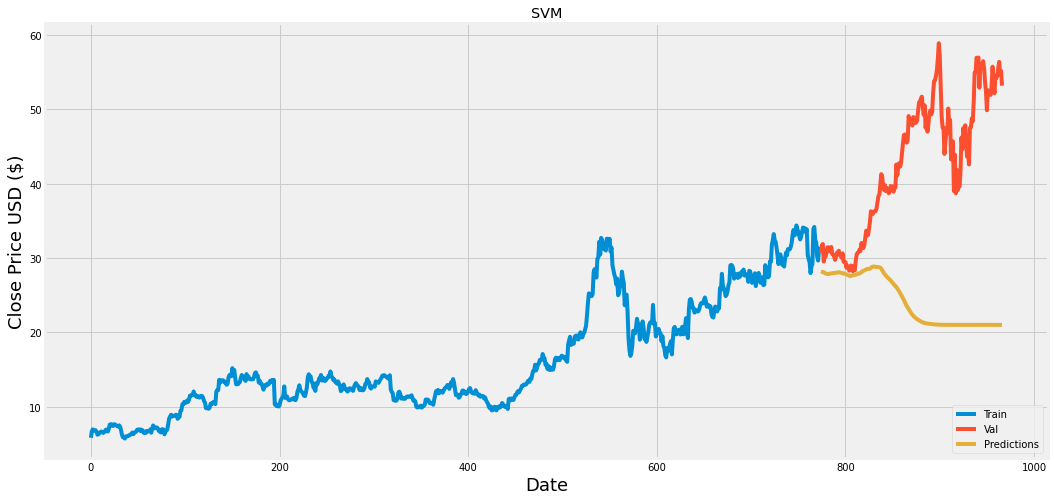

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('SVM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()